In [49]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

100%|██████████| 169001437/169001437 [00:01<00:00, 84880345.35it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


# Original classes

In [5]:
def imshow_train(images, labels, num_images=5):
    plt.figure(figsize=(15, 6))
    
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f'Класс: {labels[i]}')
        plt.axis('off')
        
    plt.show()

In [6]:
def create_data_loader(dataset):
    return torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

Train data


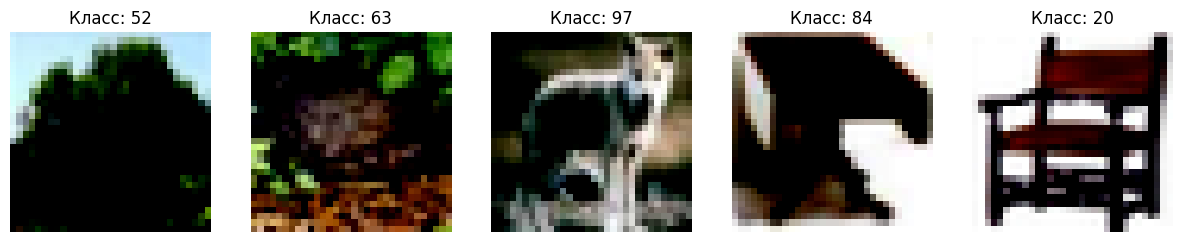

Test data


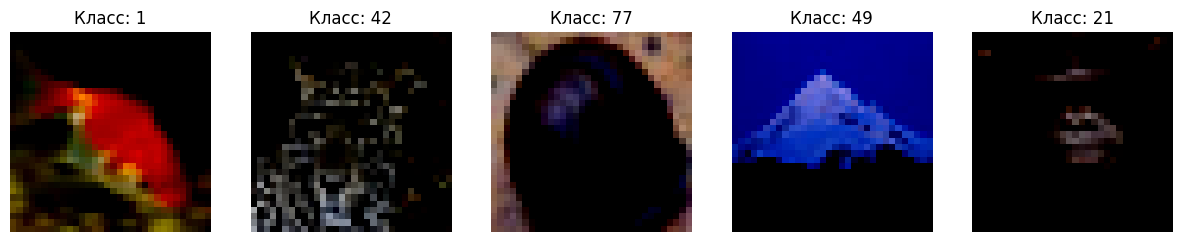

In [7]:
trainloader_orig = create_data_loader(trainset)
testloader_orig = create_data_loader(testset)

print('Train data')
train_images, train_labels = next(iter(trainloader_orig))
train_images, train_labels = train_images.to(device), train_labels.to(device)
imshow_train(train_images.cpu().numpy(), train_labels.cpu().numpy())

print('Test data')
test_images, test_labels = next(iter(testloader_orig))
test_images, test_labels = test_images.to(device), test_labels.to(device)
imshow_train(test_images.cpu().numpy(), test_labels.cpu().numpy())

# Change classes

In [8]:
bicycle_class = 19
motorcycle_class = 22
background_classes = [i for i in range(100) if i not in [bicycle_class, motorcycle_class]]

def transform_labels(y):
    if y == bicycle_class:
        return 0
    elif y == motorcycle_class:
        return 1
    else:
        return 2

In [9]:
trainset.targets = [transform_labels(y) for y in trainset.targets if y in [bicycle_class, motorcycle_class] + background_classes]
trainset.data = trainset.data[[i for i in range(len(trainset.targets)) if trainset.targets[i] in [0, 1, 2]]]

testset.targets = [transform_labels(y) for y in testset.targets if y in [bicycle_class, motorcycle_class] + background_classes]
testset.data = testset.data[[i for i in range(len(testset.targets)) if testset.targets[i] in [0, 1, 2]]]

Train data


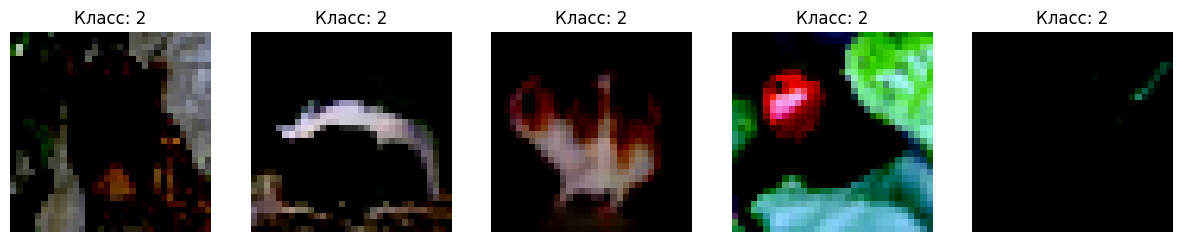

Test data


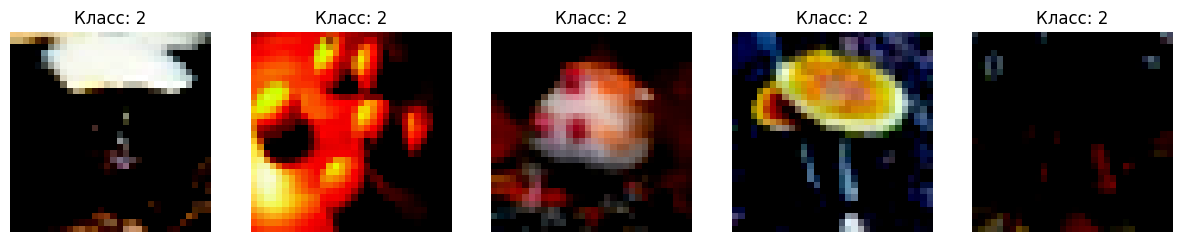

In [15]:
trainloader = create_data_loader(trainset)
testloader = create_data_loader(testset)

print('Train data')
train_images, train_labels = next(iter(trainloader))
train_images, train_labels = train_images.to(device), train_labels.to(device)
imshow_train(train_images.cpu().numpy(), train_labels.cpu().numpy())

print('Test data')
test_images, test_labels = next(iter(testloader))plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(list(range(num_epochs)), train_losses, label='Loss', color='blue')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list(range(num_epochs)), train_accuracy, label='Accuracy', color='orange')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy, %')
plt.legend()

plt.show()
test_images, test_labels = test_images.to(device), test_labels.to(device)
imshow_train(test_images.cpu().numpy(), test_labels.cpu().numpy())

# Training of pt model

In [11]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

In [31]:
def train(num_epochs, trainloader, model, optimizer, criterion):
    train_losses = []
    train_accuracies = []
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            _, predictions = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

        epoch_loss = running_loss/len(trainloader)
        epoch_accuracy = correct/total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
    
        print(f'Epochs {epoch + 1}/{num_epochs}, Loss : {epoch_loss}, Accuracy : {epoch_accuracy}')

    return train_losses, train_accuracies

In [22]:
train_losses, train_accuracies = train(num_epochs, trainloader, model, optimizer, criterion)

 10%|█         | 1/10 [00:35<05:18, 35.44s/it]

Epochs 1/10, Loss : 0.11667367911099749, Accuracy : 0.97994


 20%|██        | 2/10 [01:11<04:44, 35.56s/it]

Epochs 2/10, Loss : 0.11067976722027809, Accuracy : 0.9799


 30%|███       | 3/10 [01:46<04:07, 35.42s/it]

Epochs 3/10, Loss : 0.10837397580490861, Accuracy : 0.9798


 40%|████      | 4/10 [02:21<03:32, 35.37s/it]

Epochs 4/10, Loss : 0.10300313670355624, Accuracy : 0.97992


 50%|█████     | 5/10 [02:56<02:56, 35.37s/it]

Epochs 5/10, Loss : 0.10318632206062638, Accuracy : 0.98002


 60%|██████    | 6/10 [03:32<02:21, 35.36s/it]

Epochs 6/10, Loss : 0.09819027411042977, Accuracy : 0.97984


 70%|███████   | 7/10 [04:07<01:46, 35.36s/it]

Epochs 7/10, Loss : 0.09638688341825867, Accuracy : 0.98006


 80%|████████  | 8/10 [04:43<01:10, 35.41s/it]

Epochs 8/10, Loss : 0.09281635700629086, Accuracy : 0.98018


 90%|█████████ | 9/10 [05:18<00:35, 35.37s/it]

Epochs 9/10, Loss : 0.08664959539663493, Accuracy : 0.98014


100%|██████████| 10/10 [05:53<00:00, 35.38s/it]

Epochs 10/10, Loss : 0.09057308581102966, Accuracy : 0.97988


In [50]:
def valid(testloader):
    correct = 0
    total = 0

    predicted_labels = []
    
    model.eval()
    with torch.no_grad():
        
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_labels.extend(predicted)
    
    return correct / total, predicted_labels

In [63]:
val_acc, predicted_labels = valid(testloader)

In [52]:
print(f'Accuracy on test set: {val_acc}')

Accuracy on test set: 0.9809


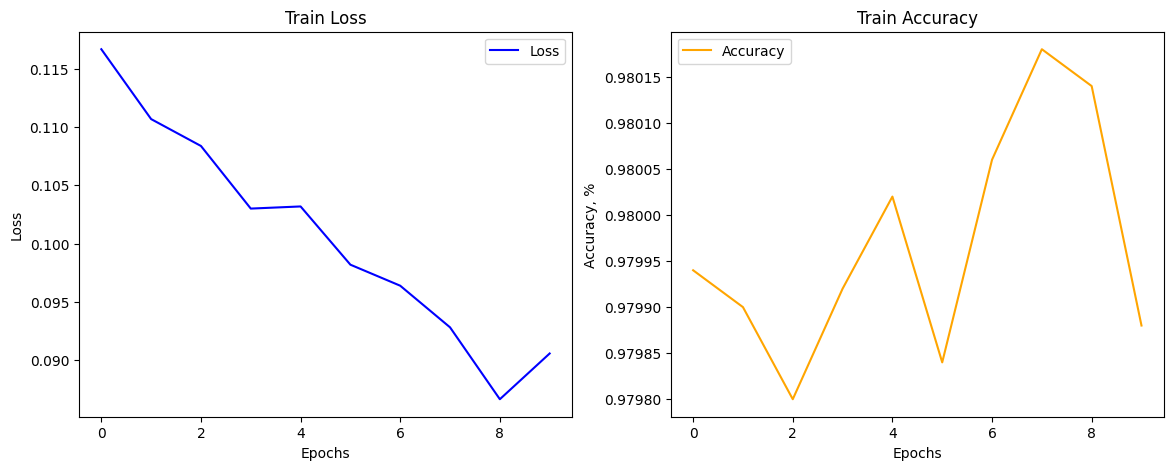

In [44]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(list(range(num_epochs)), train_losses, label='Loss', color='blue')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list(range(num_epochs)), train_accuracy, label='Accuracy', color='orange')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy, %')
plt.legend()

plt.show()

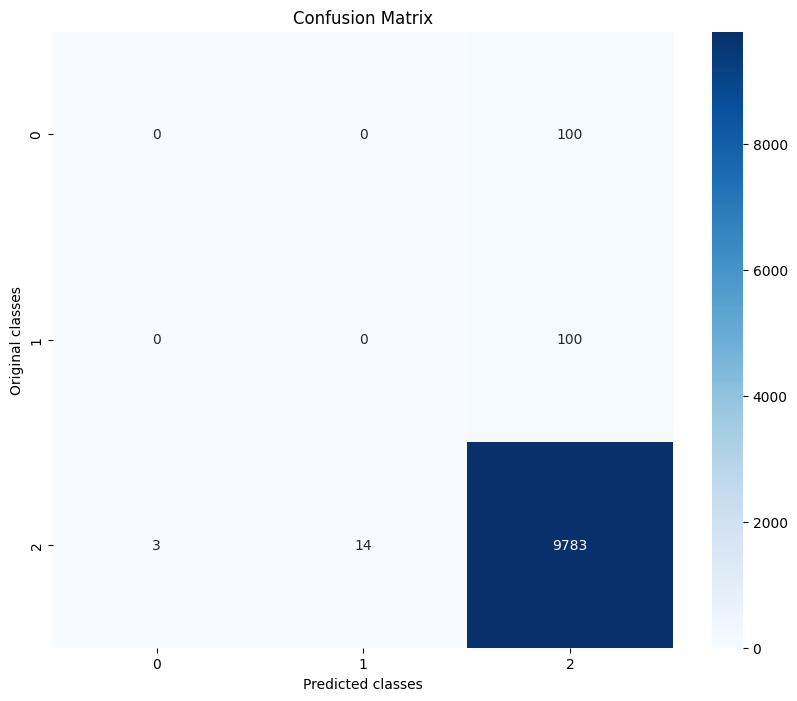

In [65]:
orig_test_labels = []
for images, labels in testloader:
    orig_test_labels.extend(labels)    
    
predicted_labels_list = [predicted_labels[i].item() for i in range(len(predicted_labels))]

cm = confusion_matrix(orig_test_labels, predicted_labels_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(len(np.unique(orig_test_labels))), yticklabels=np.arange(len(np.unique(orig_test_labels))))
plt.title('Confusion Matrix')
plt.xlabel('Predicted classes')
plt.ylabel('Original classes')
plt.show()